In [1]:
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/notebook_03/conn/spearman/test_datasets'

# 01 - Begin Analysis

Enter the path to the dictionary generated by Notebook 01

In [2]:
dict_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/notebook_01/conn/tmp/dataset_dict_testing.json'

What correlation method would you like to use?
- Pearson is very fast, but depends on linearity and is sensitive to outliers
- Spearman is slower, but much more robust

In [3]:
correlation = 'spearman'

In [4]:
from calvin_utils.ccm_utils.npy_utils import DataLoader
from calvin_utils.ccm_utils.stat_utils import CorrelationCalculator
data_loader = DataLoader(dict_path)
correlation_calculator = CorrelationCalculator(method=correlation, verbose=False)
corr_map_dict = correlation_calculator.generate_correlation_maps(data_loader)

Evaluating Epilepsy Hypometabolism
Initializaing ranked data for: Epilepsy Hypometabolism
Evaluating iEEG State Independent Stimulation
Initializaing ranked data for: iEEG State Independent Stimulation
Evaluating iEEG State Dependent Stimulation
Initializaing ranked data for: iEEG State Dependent Stimulation
Evaluating Alzheimer Fornix DBS
Initializaing ranked data for: Alzheimer Fornix DBS


Identify Datasets that Belong to Different Categories. 

Groups (values) allocate datasets to a fixed effect analysis. If no groups, set group_dict = {}
```
{
'dataset_1': 'group1',
'dataset_2': 'group2',
'dataset_3': 'group1'
}
```

In [5]:
corr_map_dict.keys()

dict_keys(['Epilepsy Hypometabolism', 'iEEG State Independent Stimulation', 'iEEG State Dependent Stimulation', 'Alzheimer Fornix DBS'])

Print out datasets

In [6]:
group_dict = {}
    # 'adni_Alzheimer' : 'Lesion',
    # 'corbetta_memory' : 'Lesion',
    # 'ms_memory' : 'Lesion',
    # 'grafmann_memory' : 'Lesion',
    # 'kahana_random_stim' : 'DBS',
    # 'queensland_memory' : 'DBS',
    # 'maastricth_memory' : 'DBS',
    # 'sante_memory' : 'DBS',
    # 'hebscher_tms' : 'TMS',
    # 'hermiller_tms_a1' : 'TMS',
    # 'hermiller_tms_b' : 'TMS',
    # 'wang_tms' : 'TMS',
    # }

# 02 - Use LOOCV to Train a Convergent Map on N-1 Datasets, Then Test it on the Nth dataset

Enter a list of datasets you want to flip (multiply correlation map by -1)
- This is typically done to control for sign inversion, enabling testing of topology specifically. 

In [7]:
datasets_to_flip = [] #['adni_Alzheimer', 'corbetta_memory', 'manitoba_memory', 'ms_memory']

Generate the Convergent Maps and Save the Individual Correlation Maps

In [8]:
from calvin_utils.ccm_utils.ccm_utils import LOOCVAnalyzer
loocv_analyzer = LOOCVAnalyzer(corr_map_dict, data_loader, 
                               convergence_type='average', 
                               similarity='spcorr',
                               method=correlation, n_bootstrap=1000, 
                               out_dir=out_dir,
                               weight=False,
                               mask_path='/Users/cu135/hires_backdrops/MNI/MNI152_T1_2mm_brain_mask.nii',
                               roi_path='/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/notebook_03/conn/spearman/convergence_maps/Lesion_weighted_average_r_map.nii.gz',
                               datasets_to_flip=datasets_to_flip
                               )

Removing NaNS from self.coor_map_dict.


Generate Agreement Maps

In [9]:
loocv_analyzer.generate_and_save_maps(group_dict=group_dict, dir='convergence_maps/', verbose=False)


Generate Group Level Maps

In [10]:
loocv_analyzer.save_individual_r_maps(dir='group_maps/', verbose=False)

Run LOOCV

In [11]:
loocv_analyzer.run()
display(loocv_analyzer.results_df)

Evaluating dataset: Epilepsy Hypometabolism


Running bootstraps: 100%|██████████| 1000/1000 [00:00<00:00, 7737.37it/s]


Evaluating dataset: iEEG State Independent Stimulation


Running bootstraps: 100%|██████████| 1000/1000 [00:00<00:00, 6769.29it/s]


Evaluating dataset: iEEG State Dependent Stimulation


Running bootstraps: 100%|██████████| 1000/1000 [00:00<00:00, 7964.70it/s]


Evaluating dataset: Alzheimer Fornix DBS


Running bootstraps: 100%|██████████| 1000/1000 [00:00<00:00, 7993.09it/s]


,Dataset,CI Lower,CI Upper,Mean R
0,Epilepsy Hypometabolism,0.085601,0.693273,0.425392
1,iEEG State Independent Stimulation,-0.271980,0.363352,0.058450
2,iEEG State Dependent Stimulation,-0.393824,0.230430,-0.097931
3,Alzheimer Fornix DBS,0.225258,0.643064,0.451030


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# 03 - Compute Fixed Effects

Run It

In [12]:
import pandas as pd
df = loocv_analyzer.compute_fixed_effects_by_group(group_dict)
meta_df = pd.concat([loocv_analyzer.results_df, df], ignore_index=True)
meta_df

,Dataset,CI Lower,CI Upper,Mean R
0,Epilepsy Hypometabolism,0.085601,0.693273,0.425392
1,iEEG State Independent Stimulation,-0.271980,0.363352,0.058450
2,iEEG State Dependent Stimulation,-0.393824,0.230430,-0.097931
3,Alzheimer Fornix DBS,0.225258,0.643064,0.451030
4,Overall Fixed Effects,0.065790,0.378558,0.228049


# 04 - Visualize Your Meta Analysis as a Forest Plot Figure 
- This is a meta-analysis. It presents the effect size (R/rho values) of your convergent map on the left-out map. 

Generate a Forest Plot of the Results

Saved to /Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/notebook_03/conn/spearman/test_datasets as meta_convergence_forest_plot.svg and .png


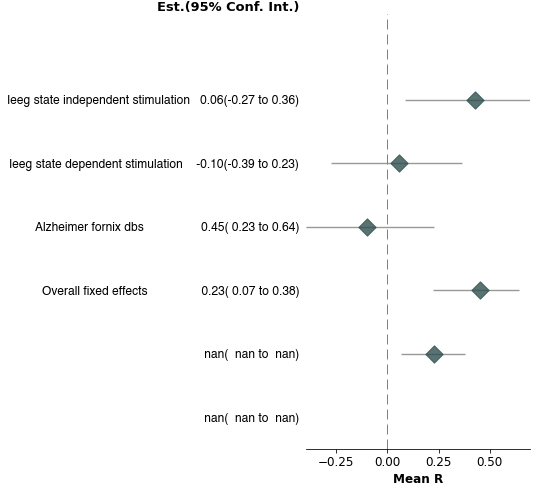

In [13]:
from calvin_utils.ccm_utils.stat_utils import MetaConvergenceForestPlot
meta_forest_plot = MetaConvergenceForestPlot(meta_df, sig_digits=2, out_dir=out_dir, table=True)
meta_forest_plot.run()

That's all

-Calvin